# Identification of Financial Fraud in Listed Companies—A Machine Learning Approach Using LightGBM and XGBoost

## Background

Over the past decade or so, incidents of financial fraud in listed companies have emerged repeatedly, severely undermining investor interests and affecting the healthy development of capital markets. Even authoritative supervisory bodies, such as the China Securities Regulatory Commission, have identified only a limited number of fraud cases, and their detection is generally delayed. This paper employs emerging machine learning techniques to predict corporate financial fraud. Specifically, financial ratio indicators are selected as initial input variables alongside non-financial indicators such as textual information and internal control measures. An undersampling method is applied to address the imbalance in the training set, and the LightGBM algorithm is adopted to establish a classification model to determine whether a company has committed fraud.

## Variable Selection

In this project, we refer to Liu Yunjing et al. (2022)’s study 基于新兴机器学习算法对于上市公司财务舞弊识别模型设计及其应用研究 to select eleven variables: turnover tax rate (F032501B), comprehensive tax rate A (F032601B), largest shareholder holding ratio (LargestHolderRate), common stock profitability rate A (F101201B), internal control index (innercontrol), growth rate of selling expenses (F081901B), financial expense ratio (F051901B), management expense ratio (F051801B), current liabilities ratio (F031501A), tone of management discussion and analysis (ManagementTone), and textual complexity (Fog).

**It is noteworthy that, due to the lack of access to an internal control index database, this project constructs a new internal control index based on the proportion of independent directors and the extent of their participation on the board.**

Furthermore, based on Fuhaoliang et al. (2021)’s study on the tone of annual reports, **this project expands the scope of tone analysis from solely management content to an analysis of the entire annual report in order to achieve a more comprehensive evaluation.**

Regarding tone selection, George (2016) demonstrates that companies with lower levels of earnings manipulation and higher leverage tend to exhibit a higher overall proportion of pessimistic language, whereas high-growth companies display less pessimism. Companies with elevated levels of pessimism tend to maintain a conservative stance even in the face of bad news or low cash flow. Firms using pessimistic language often exhibit stronger corporate governance. **The use of pessimistic language is positively correlated with prediction accuracy and analyst coverage.** Annual reports tend to be more pessimistic to guide analysts in lowering their expectations to achieve target returns. Companies that meet or barely exceed analyst forecasts tend to employ less pessimistic language; on the other hand, they may use pessimistic language to mitigate the market’s negative reaction to underperformance. **Therefore, this project calculates the proportion of pessimistic tone as the value for the management discussion and analysis tone variable.**

Finally, de Souza et al. (2018) indicate that, according to the management obfuscation hypothesis, companies with negative earnings produce financial reports of lower readability because managers tend to use complex language to conceal poor performance, resulting in information obfuscation (Li 2008 cited in João et al. 2018). Bloomfield (2008 cited in João et al. 2018) provides two additional plausible explanations. He argues that negative earnings prompt managers to offer more explanations to stakeholders to reduce the adverse impacts of poor performance, and that, in line with the accounting principle of conservatism, companies are required to provide more explanatory information to aid in analyzing future prospects. **In summary, the complexity of financial reports is negatively correlated with a company’s operational performance.** The more complex the text, the more likely the company is to have incurred negative earnings in the past year (João et al. 2018). Therefore, this project incorporates textual complexity as a variable to enhance the accuracy of the model.

## Data Source

The financial data for this project are derived from the CSMAR database. The annual reports are sourced from the CNINFO website; after crawling and downloading all listed companies’ annual reports, the text is extracted and processed using custom-built Fog and Emotion functions to obtain the variables for textual complexity and sentiment index.

# Data Preprocessing Section

### Data Collection

### Downloading annual reports (Using a web crawler, we downloaded annual reports from the CNINFO website for all listed companies across all available years, totaling approximately 30,000 documents.)

In [15]:
import pandas as pd

### Extract the text from annual reports and pass it to the text processing function (using multiprocessing techniques, to be run in a non-interactive environment such as Spyder).

### Largest Holder Rate

In [16]:
LargeHolderRate = pd.read_excel(r'data//EN_EquityNatureAll.xlsx')
LargeHolderRate.rename(columns={'EndDate': 'Date',"Symbol":"Stkcd"}, inplace=True)
LargeHolderRate.drop(columns=["ShortName"], inplace=True)

LargeHolderRate

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Date,LargestHolderRate
0,证券代码,截止日期,第一大股东持股比率(%)
1,没有单位,没有单位,没有单位
2,000001,2003-12-31,7.08
3,000001,2004-12-31,17.89
4,000001,2005-12-31,17.89
...,...,...,...
53728,900957,2018-12-31,29.62
53729,900957,2019-12-31,29.62
53730,900957,2020-12-31,29.62
53731,900957,2021-12-31,29.62


### Internal Control Strength

Replace with the proportion of independent directors on the board and the number of meetings attended by independent directors.

In [17]:
Independent1 = pd.read_excel(r'data//CG_Cxhy.xlsx') # the proportion of independent directors
Independent1 .rename(columns={'Reptdt': 'Date'}, inplace=True)
Independent1.drop(columns=['Indepname'], inplace=True)
Independent1

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Date,Attennum1,Attennum3
0,证券代码,统计截止日期,应参加次数,缺席次数
1,没有单位,没有单位,次,次
2,000001,2004-12-31,1,0
3,000001,2004-12-31,1,0
4,000001,2004-12-31,1,0
...,...,...,...,...
194399,900957,2020-12-31,3,0
194400,900957,2021-12-31,4,0
194401,900957,2021-12-31,4,0
194402,900957,2022-12-31,4,0


In [18]:
# Sum ‘Attennum1’ and ‘Attennum3’ columns, grouped by ‘Stkcd’ and ‘Date’.
Independent1 = Independent1.groupby(['Stkcd', 'Date']).agg({
    'Attennum1': 'sum',  # Total number of participations
    'Attennum3': 'sum'   # Total number of absence
}).reset_index()

Independent1 = Independent1.iloc[:-2]

Independent1


,Stkcd,Date,Attennum1,Attennum3
0,000001,2004-12-31,33,0
1,000001,2005-12-31,44,0
2,000001,2006-12-31,48,0
3,000001,2007-12-31,67,1
4,000001,2008-12-31,37,0
...,...,...,...,...
52417,900957,2018-12-31,12,0
52418,900957,2019-12-31,12,0
52419,900957,2020-12-31,12,0
52420,900957,2021-12-31,8,0


In [19]:
Independent2 = pd.read_excel(r"data//CG_ManagerShareSalary.xlsx") #Number of Board of Directors and Independent Directors
Independent2 .rename(columns={'Reptdt': 'Date'}, inplace=True)

#Statistical calibre distinction is made for all statistical indicators in the table, 
#where 1 = personnel on board at the end of the year and 2 = all personnel during the year (including separated, active, retired, etc.).
Independent2= Independent2[Independent2['StatisticalCaliber'] == "2"]

Independent2.drop(columns=['StatisticalCaliber'], inplace=True)
Independent2.rename(columns={'Enddate': 'Date',"Symbol":"Stkcd"}, inplace=True)
Independent2

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Date,DirectorNumber,IndependentDirectorNumber
3,000001,1999-12-31,11,0
4,000001,2000-12-31,11,0
6,000001,2001-12-31,14,3
8,000001,2002-12-31,15,3
11,000001,2003-12-31,14,3
...,...,...,...,...
116357,900957,2018-12-31,9,3
116358,900957,2019-12-31,9,3
116361,900957,2020-12-31,11,5
116362,900957,2021-12-31,6,2


### Turnover tax rate (F032501B) Combined tax rate A (F032601B)

In [20]:
TaxRatio = pd.read_excel(r"data//FI_T3.xlsx") #Turnover tax rate(F032501B) Combined tax rateA(F032601B)
TaxRatio.rename(columns={'Accper': 'Date'}, inplace=True)
TaxRatio = TaxRatio[TaxRatio['Typrep'] == 'A'] # Retain only statements with Typrep A (consolidated financial statements)
TaxRatio = TaxRatio[TaxRatio['Date'].str.endswith('12-31')] #Only data from 12.31 are retained
TaxRatio.drop(columns=['Typrep',"ShortName"], inplace=True)
TaxRatio

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Date,F032501B,F032601B
2,000001,1990-12-31,NaN,NaN
3,000001,1991-12-31,NaN,NaN
4,000001,1992-12-31,NaN,NaN
5,000001,1993-12-31,0.063411,0.179013
7,000001,1994-12-31,0.076944,0.164656
...,...,...,...,...
486302,900957,2018-12-31,0.000932,0.002039
486310,900957,2019-12-31,0.002191,0.014255
486318,900957,2020-12-31,0.003409,0.016687
486325,900957,2021-12-31,0.013074,0.037307


### Current liabilities ratio (F031501A)

In [21]:
TaxRatio2 = pd.read_excel(r"data//FI_T3 2.xlsx") #Current liabilities ratio
TaxRatio2.rename(columns={'Accper': 'Date'}, inplace=True)

TaxRatio2 = TaxRatio2[TaxRatio2['Typrep'] == 'A']# Retain only those statements with a Typrep of A
TaxRatio2 = TaxRatio2[TaxRatio2['Date'].str.endswith('12-31')]#Only data from 12.31 are retained
TaxRatio2.drop(columns=['Typrep',"ShortName"], inplace=True)
TaxRatio2

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Date,F031501A
2,000001,1990-12-31,1
3,000001,1991-12-31,1
4,000001,1992-12-31,1
5,000001,1993-12-31,NaN
7,000001,1994-12-31,NaN
...,...,...,...
486302,900957,2018-12-31,0.173931
486310,900957,2019-12-31,0.21815
486318,900957,2020-12-31,0.161885
486325,900957,2021-12-31,0.220173


### Finance expense ratio (F051801B) Administrative expense ratio (F051901B)

In [22]:
ExpenseRatio = pd.read_excel(r"data//FI_T5.xlsx") #Finance expense ratio and Administrative expense ratio
ExpenseRatio.rename(columns={'Accper': 'Date'}, inplace=True)
ExpenseRatio = ExpenseRatio[ExpenseRatio['Typrep'] == 'A']
ExpenseRatio.drop(columns=['Typrep',"ShortName"], inplace=True)
ExpenseRatio = ExpenseRatio[ExpenseRatio['Date'].str.endswith('12-31')]
ExpenseRatio

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Date,F051801B,F051901B
2,000001,1991-12-31,NaN,NaN
3,000001,1992-12-31,NaN,NaN
5,000001,1993-12-31,NaN,NaN
7,000001,1994-12-31,NaN,NaN
9,000001,1995-12-31,NaN,NaN
...,...,...,...,...
491534,900957,2018-12-31,0.062048,0.32562
491542,900957,2019-12-31,0.084625,0.311451
491550,900957,2020-12-31,0.078688,0.303068
491557,900957,2021-12-31,0.063236,0.254757


### Cost of sales growth rate (F081901B)

In [23]:
SaleExpense = pd.read_excel(r"data//FI_T8.xlsx") #Cost of sales growth rate
SaleExpense.rename(columns={'Accper': 'Date'}, inplace=True)
SaleExpense = SaleExpense[SaleExpense['Typrep'] == 'A']
SaleExpense.drop(columns=['Typrep',"ShortName"], inplace=True)
SaleExpense = SaleExpense[SaleExpense['Date'].str.endswith('12-31')]
SaleExpense

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Date,F081901B
2,000001,1991-12-31,NaN
3,000001,1992-12-31,NaN
4,000001,1993-12-31,NaN
6,000001,1994-12-31,NaN
8,000001,1995-12-31,NaN
...,...,...,...
485995,900957,2018-12-31,NaN
486003,900957,2019-12-31,NaN
486011,900957,2020-12-31,NaN
486018,900957,2021-12-31,NaN


### Ordinary share entitlement rate A (F101201B)

In [24]:
ReturnonStock = pd.read_excel(r"data//FI_T10.xlsx") #Ordinary share entitlement rateA
ReturnonStock.rename(columns={'Accper': 'Date'}, inplace=True)
ReturnonStock.drop(columns=["ShortName"], inplace=True)
ReturnonStock = ReturnonStock[ReturnonStock['Date'].str.endswith('12-31')]
ReturnonStock

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Date,F101201B
2,000001,1991-12-31,0
3,000001,1992-12-31,0
4,000001,1993-12-31,0
6,000001,1994-12-31,0
8,000001,1995-12-31,0
...,...,...,...
231026,900957,2018-12-31,0
231030,900957,2019-12-31,0
231034,900957,2020-12-31,0
231038,900957,2021-12-31,0


### Violation

In [25]:
Violation = pd.read_excel(r"data//STK_Violation_Main.xlsx")
Violation.drop(columns=['ViolationID'], inplace=True)
Violation = Violation[Violation['ViolationTypeID'].str.contains('P2501|P2502', na=False)] 

#Based on the reference paper, we finally choose two types of listed companies with violations, 
#namely fictitious profits and misrepresentation of assets, as the companies in which financial fraud occurs.
Violation

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Symbol,DisposalDate,DeclareDate,ViolationTypeID,ViolationYear
130,000018,2019-03-06,2019-03-07,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2015;2016;2017;2018;N/A
134,000018,2020-10-13,2020-10-13,P2501、P2504;P2503、P2505;P2505,2017;2018;2019
178,000034,2007-08-30,2007-08-30,P2505、P2599;P2502、P2503、P2505、P2510、P2599,2003;2004
216,000038,2022-08-25,2022-08-26,P2501、P2599;P2501、P2503、P2599;P2503、P2599,2016;2017;2018
219,000038,2023-06-08,2023-06-09,P2501、P2599;P2501、P2503、P2599;P2503、P2599,2016;2017;2018
...,...,...,...,...,...
17340,688316,2022-07-27,2022-07-27,P2501、P2503、P2599,2021
17342,688317,2019-07-08,2019-07-08,P2501、P2503、P2599;P2505、P2599,2016;N/A
17391,688555,2022-11-18,2022-11-19,P2501、P2503;P2501、P2502、P2503;P2501、P2503,2020;2021;2022
17395,688555,2023-06-29,2023-06-30,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2019;2021;2022


In [26]:
# Delete ‘DisposalDate’ and ‘DeclareDate’ Columns
Violation.drop(columns=['DisposalDate', 'DeclareDate'], inplace=True)

# Change ‘Symbol’ column name to ‘Stkcd’
Violation.rename(columns={'Symbol': 'Stkcd'}, inplace=True)
Violation

,Stkcd,ViolationTypeID,ViolationYear
130,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2015;2016;2017;2018;N/A
134,000018,P2501、P2504;P2503、P2505;P2505,2017;2018;2019
178,000034,P2505、P2599;P2502、P2503、P2505、P2510、P2599,2003;2004
216,000038,P2501、P2599;P2501、P2503、P2599;P2503、P2599,2016;2017;2018
219,000038,P2501、P2599;P2501、P2503、P2599;P2503、P2599,2016;2017;2018
...,...,...,...
17340,688316,P2501、P2503、P2599,2021
17342,688317,P2501、P2503、P2599;P2505、P2599,2016;N/A
17391,688555,P2501、P2503;P2501、P2502、P2503;P2501、P2503,2020;2021;2022
17395,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2019;2021;2022


In [27]:
# Decompose the ‘ViolationYear’ and ‘ViolationTypeID’ columns to create multiple rows for each year and violation type
Violation = Violation.assign(ViolationYear=Violation['ViolationYear'].str.split(';'))
Violation = Violation.explode('ViolationYear', ignore_index=True)


Violation['ViolationYear'] = Violation['ViolationYear'].replace("N/A", pd.NaT)

# Drop NaN values
Violation.dropna(subset=['ViolationYear'], inplace=True)

# delete values that is not year
Violation = Violation[Violation['ViolationYear'].str.isnumeric()]

# Group by ‘Stkcd’ and ‘ViolationYear’ to remove distinction based on ViolationTypeID
grouped_Violation = Violation.groupby(['Stkcd', 'ViolationYear']).size().reset_index()

# Remove size columns added with the size() function
grouped_Violation.drop(columns=[0], inplace=True)

Violation

,Stkcd,ViolationTypeID,ViolationYear
0,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2015
1,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2016
2,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2017
3,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2018
5,000018,P2501、P2504;P2503、P2505;P2505,2017
...,...,...,...
1924,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2021
1925,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2022
1926,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2019
1927,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2021


In [28]:
Violation

,Stkcd,ViolationTypeID,ViolationYear
0,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2015
1,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2016
2,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2017
3,000018,P2599;P2501、P2599;P2501、P2504、P2515、P2599;P259...,2018
5,000018,P2501、P2504;P2503、P2505;P2505,2017
...,...,...,...
1924,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2021
1925,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2022
1926,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2019
1927,688555,P2501、P2503、P2505、P2507、P2599;P2501、P2503、P250...,2021


In [29]:
# Rename 'ViolationYear' to 'Date'
Violation.rename(columns={'ViolationYear': 'Date'}, inplace=True)

# Convert 'Date' values to the format YYYY-12-31
Violation['Date'] = Violation['Date'] + '-12-31'

# Add a new column 'Violation' with value 1
Violation['Violation'] = 1

Violation.drop(columns=['ViolationTypeID'], inplace=True)

Violation 

,Stkcd,Date,Violation
0,000018,2015-12-31,1
1,000018,2016-12-31,1
2,000018,2017-12-31,1
3,000018,2018-12-31,1
5,000018,2017-12-31,1
...,...,...,...
1924,688555,2021-12-31,1
1925,688555,2022-12-31,1
1926,688555,2019-12-31,1
1927,688555,2021-12-31,1


### Consolidated indicators

In [30]:
# Merge by ‘Stkcd’, ‘ShortName’, ‘Date’
merged_df = LargeHolderRate.merge(Independent1, on=['Stkcd','Date'], how='outer')
merged_df = merged_df.merge(Independent2, on=['Stkcd', 'Date'], how='outer')
merged_df = merged_df.merge(TaxRatio, on=['Stkcd', 'Date'], how='outer')
merged_df = merged_df.merge(TaxRatio2, on=['Stkcd','Date'], how='outer')
merged_df = merged_df.merge(ExpenseRatio, on=['Stkcd','Date'], how='outer')
merged_df = merged_df.merge(SaleExpense, on=['Stkcd','Date'], how='outer')
merged_df = merged_df.merge(ReturnonStock, on=['Stkcd', 'Date'], how='outer')

merged_df


,Stkcd,Date,LargestHolderRate,Attennum1,Attennum3,DirectorNumber,IndependentDirectorNumber,F032501B,F032601B,F031501A,F051801B,F051901B,F081901B,F101201B
0,证券代码,截止日期,第一大股东持股比率(%),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,没有单位,没有单位,没有单位,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000001,2003-12-31,7.08,NaN,NaN,14,3,0.080664,0.092618,NaN,NaN,NaN,NaN,0
3,000001,2004-12-31,17.89,33,0,13,5,0.091802,0.136754,NaN,NaN,NaN,NaN,0
4,000001,2005-12-31,17.89,44,0,14,4,0.091475,0.15442,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77842,601958,2005-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042279,-0.001934,NaN,NaN
77843,601989,2006-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.098897,0.010879,NaN,NaN
77844,601989,2007-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.084481,0.006301,NaN,NaN
77845,601999,2004-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.103309,-0.002911,NaN,NaN


###  Internal control factor

Lack of corresponding database, so internal control factor simulation is carried out

Simulation using the proportion of independent directors and the participation of independent directors, give these two factors a weight of 0.5 and add them up to get the strength of internal control, the closer it is to 1, it means that the higher the participation of independent directors, the stronger the internal control is

$$
InternalControlStrength = 0.5 \times [ \frac { IndependentDirectorNumber } { DirectorNumber } +  \frac {1- Attennum3} { Attennum1 } ]
$$

In [31]:

merged_df['IndependentDirectorNumber'] = pd.to_numeric(merged_df['IndependentDirectorNumber'], errors='coerce')
merged_df['DirectorNumber'] = pd.to_numeric(merged_df['DirectorNumber'], errors='coerce')
merged_df['Attennum3'] = pd.to_numeric(merged_df['Attennum3'], errors='coerce')
merged_df['Attennum1'] = pd.to_numeric(merged_df['Attennum1'], errors='coerce')

# Proportion of independent directors
merged_df['IndependentDirectorRatio'] = merged_df['IndependentDirectorNumber'] / merged_df['DirectorNumber']

# Participation rate of independent directors
merged_df['IndependentDirectorAttendance'] = 1 - (merged_df['Attennum3'] / merged_df['Attennum1'])

# Internal control strength
merged_df['InternalControlStrength'] = 0.5 * merged_df['IndependentDirectorRatio'] + 0.5 * merged_df['IndependentDirectorAttendance']

merged_df[['Stkcd', 'Date', 'InternalControlStrength']].head(10)


,Stkcd,Date,InternalControlStrength
0,证券代码,截止日期,NaN
1,没有单位,没有单位,NaN
2,000001,2003-12-31,NaN
3,000001,2004-12-31,0.692308
4,000001,2005-12-31,0.642857
5,000001,2006-12-31,0.653846
6,000001,2007-12-31,0.635394
7,000001,2008-12-31,0.642857
8,000001,2009-12-31,0.666667
9,000001,2010-12-31,0.656250


In [32]:
merged_df

,Stkcd,Date,LargestHolderRate,Attennum1,Attennum3,DirectorNumber,IndependentDirectorNumber,F032501B,F032601B,F031501A,F051801B,F051901B,F081901B,F101201B,IndependentDirectorRatio,IndependentDirectorAttendance,InternalControlStrength
0,证券代码,截止日期,第一大股东持股比率(%),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,没有单位,没有单位,没有单位,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000001,2003-12-31,7.08,NaN,NaN,14.0,3.0,0.080664,0.092618,NaN,NaN,NaN,NaN,0,0.214286,NaN,NaN
3,000001,2004-12-31,17.89,33.0,0.0,13.0,5.0,0.091802,0.136754,NaN,NaN,NaN,NaN,0,0.384615,1.0,0.692308
4,000001,2005-12-31,17.89,44.0,0.0,14.0,4.0,0.091475,0.15442,NaN,NaN,NaN,NaN,0,0.285714,1.0,0.642857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77842,601958,2005-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042279,-0.001934,NaN,NaN,NaN,NaN,NaN
77843,601989,2006-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.098897,0.010879,NaN,NaN,NaN,NaN,NaN
77844,601989,2007-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.084481,0.006301,NaN,NaN,NaN,NaN,NaN
77845,601999,2004-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.103309,-0.002911,NaN,NaN,NaN,NaN,NaN


In [33]:
merged_df.drop(columns=['Attennum1','Attennum3','DirectorNumber','IndependentDirectorNumber','IndependentDirectorRatio','IndependentDirectorAttendance'], inplace=True)

In [34]:
merged_df

,Stkcd,Date,LargestHolderRate,F032501B,F032601B,F031501A,F051801B,F051901B,F081901B,F101201B,InternalControlStrength
0,证券代码,截止日期,第一大股东持股比率(%),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,没有单位,没有单位,没有单位,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000001,2003-12-31,7.08,0.080664,0.092618,NaN,NaN,NaN,NaN,0,NaN
3,000001,2004-12-31,17.89,0.091802,0.136754,NaN,NaN,NaN,NaN,0,0.692308
4,000001,2005-12-31,17.89,0.091475,0.15442,NaN,NaN,NaN,NaN,0,0.642857
...,...,...,...,...,...,...,...,...,...,...,...
77842,601958,2005-12-31,NaN,NaN,NaN,NaN,0.042279,-0.001934,NaN,NaN,NaN
77843,601989,2006-12-31,NaN,NaN,NaN,NaN,0.098897,0.010879,NaN,NaN,NaN
77844,601989,2007-12-31,NaN,NaN,NaN,NaN,0.084481,0.006301,NaN,NaN,NaN
77845,601999,2004-12-31,NaN,NaN,NaN,NaN,0.103309,-0.002911,NaN,NaN,NaN


### Non-financial data indicators - text sentiment analysis and text complexity analysis

### Text sentiment analysis

Sentiment analysis (SENTIMENT ANALYSIS) is a computer science technical term published in 2018.
It can determine whether the meaning represented is positive or negative based on the content of the text, and can also be used to analyse whether the meaning in the text is positive or negative.

The general application scenario is that it can be used to do the analysis of a large amount of review data from e-commerce, such as the statistics of the positive or negative review rate and so on.

We use here to the sentiment analysis module is snownlp, in order to improve the accuracy of sentiment analysis choose to join the jieba module of the word processing.

First, we need to define the text data for analysis. Once the dataset is prepared, the next step is word segmentation.

The reason for performing word segmentation is that SnowNLP, a sentiment analysis module for Chinese, does not always produce accurate word splits.

For example, the phrase "不好看" (which means "not good-looking" or "ugly") might be incorrectly segmented by SnowNLP into "不" (not) and "好看" (good-looking). As a result, the sentiment of the word could be misclassified as positive instead of negative.

To prevent such errors, we first use jieba, a more precise Chinese word segmentation tool, before applying sentiment analysis.

In [35]:
import pandas as pd

# Specify the dtype for the 'Stkcd' column to be str when reading the Excel file
Emotion = pd.read_excel(r"data//情感分析1.1.xlsx", dtype={'股票代码': str})

# Rename the columns as specified
Emotion.rename(columns={"股票代码":"Stkcd","年份":"Date","情感指数": "EmotionIndex"}, inplace=True)

# Convert 'Date' column to string and append '-12-31'
Emotion['Date'] = Emotion['Date'].astype(str)+'-12-31'

# Now the 'Stkcd' column will be treated as strings with any leading zeros preserved
Emotion


,Stkcd,Date,EmotionIndex
0,000001,2001-12-31,0.578495
1,000001,2002-12-31,0.471260
2,000001,2003-12-31,0.498761
3,000001,2004-12-31,0.483761
4,000001,2005-12-31,0.457115
...,...,...,...
29324,900957,2008-12-31,0.596026
29325,900957,2009-12-31,0.670251
29326,900957,2010-12-31,0.527451
29327,900957,2011-12-31,0.474453


### Text Complexity Analysis (Fog Index)

Text complexity refers to the relative difficulty of reading, writing, or understanding a document, or a combination of these activities. Accounting and finance researchers have shown particular interest in the complexity of corporate information disclosures. Complex disclosures are harder to read and comprehend, increasing the processing costs for information users.

Researchers have proposed several reasons why some companies’ textual disclosures are more complex than others. For instance, complex reports may be a deliberate attempt by managers to obscure information or conceal poor company performance (Li, 2008; Lo et al., 2017). On the other hand, complex disclosures may result from intricate business operations and regulatory reporting requirements rather than intentional obfuscation by company management (Guay et al., 2016; Dyer et al., 2017; Chychyla et al., 2019).

Regardless of the reason, complex disclosures are associated with negative externalities, such as reduced transparency in the information environment (You & Zhang, 2009; Lehavy et al., 2011) and an increased risk of financial misreporting (Filzen & Peterson, 2015; Hoitash & Hoitash, 2018).

### Fog index
The Gunning fog index is a numerical score assigned to an input text, with larger values indicating a greater difficulty in reading the text. The reading levels for each grade level correspond approximately to the following Gunning fog index scores.

| Grade                 | Fog index |
| --------------------- | --------- |
| Sixth grade           | 6         |
| Seventh grade         | 7         |
| Eighth grade          | 8         |
| High school freshman  | 9         |
| High school sophomore | 10        |
| High school junior    | 11        |
| High school senior    | 12        |
| College freshman      | 13        |
| College sophomore     | 14        |
| College junior        | 15        |
| College senior        | 16        |
| College graduate      | 17        |

For a given text, the score is calculated as a weighted sum of the average number of words per sentence and the average number of complex words per word (i.e., words with three or more syllables):
$$
Fog  \ index= 0.4 \times [ \frac { all\  words } { all \ sentences } + 100 \times \frac {complex \ words  } { all \ words } ]
$$

**Note: It is worth noting that the Misty Index was created for English text, although we can make it apply to Chinese text by some methods, and its complexity index does not correspond to English text. In addition, due to the difficulty of Chinese words is difficult to determine, my group considers words more than three characters long as complex words. **



In [36]:
import pandas as pd
import numpy as np

Fog=pd.read_excel(r"data//FOG指数.xlsx")
Fog = Fog.astype('object')
Fog.rename(columns={'年份': 'Date',"股票代码":"Stkcd", "FOG指数":"Fog"}, inplace=True)

# Convert 'Date' values to the format YYYY-12-31
Fog['Date'] = Fog['Date'].astype(str)+"-12-31"

# Now, let's drop the rows where 'Date' does not represent a valid year (not four digits)
Fog = Fog[Fog['Date'].str.contains(r'^\d{4}-12-31$')]

# Drop rows where 'Stkcd' column has missing values
Fog.replace('NoneNo', np.nan, inplace=True)
Fog.dropna(subset=['Stkcd'], inplace=True)

Fog

,Stkcd,Date,Fog
0,000001,2006-12-31,24.610256
1,000001,2001-12-31,15.057991
2,000001,2002-12-31,15.522826
3,000001,2003-12-31,13.879444
4,000001,2004-12-31,17.066854
...,...,...,...
29904,900957,2001-12-31,28.073016
29905,900957,2002-12-31,26.566307
29906,900957,2003-12-31,49.317434
29907,900957,2004-12-31,28.841450


## Merge data

In [37]:
merged_df = merged_df.merge(Emotion, on=['Stkcd', 'Date'], how='outer')
merged_df = merged_df.merge(Fog, on=['Stkcd', 'Date'], how='outer')

In [38]:
merged_df

,Stkcd,Date,LargestHolderRate,F032501B,F032601B,F031501A,F051801B,F051901B,F081901B,F101201B,InternalControlStrength,EmotionIndex,Fog
0,证券代码,截止日期,第一大股东持股比率(%),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,没有单位,没有单位,没有单位,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000001,2003-12-31,7.08,0.080664,0.092618,NaN,NaN,NaN,NaN,0,NaN,0.498761,13.879444
3,000001,2004-12-31,17.89,0.091802,0.136754,NaN,NaN,NaN,NaN,0,0.692308,0.483761,17.066854
4,000001,2005-12-31,17.89,0.091475,0.15442,NaN,NaN,NaN,NaN,0,0.642857,0.457115,15.898434
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79077,420047,2003-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.548170,27.261905
79078,600408,2002-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79079,603125,2023-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.504114,23.164080
79080,01108洛,2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.783136


## Merge violation data

In [39]:
merged_df = merged_df.merge(Violation, on=['Stkcd', 'Date'], how='outer')
merged_df['Violation'].fillna(0, inplace=True)
merged_df

,Stkcd,Date,LargestHolderRate,F032501B,F032601B,F031501A,F051801B,F051901B,F081901B,F101201B,InternalControlStrength,EmotionIndex,Fog,Violation
0,证券代码,截止日期,第一大股东持股比率(%),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,没有单位,没有单位,没有单位,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,000001,2003-12-31,7.08,0.080664,0.092618,NaN,NaN,NaN,NaN,0,NaN,0.498761,13.879444,0.0
3,000001,2004-12-31,17.89,0.091802,0.136754,NaN,NaN,NaN,NaN,0,0.692308,0.483761,17.066854,0.0
4,000001,2005-12-31,17.89,0.091475,0.15442,NaN,NaN,NaN,NaN,0,0.642857,0.457115,15.898434,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79945,688086,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
79946,688317,2016-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
79947,688555,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
79948,688555,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [40]:
merged_df.drop_duplicates(inplace=True)
merged_df

,Stkcd,Date,LargestHolderRate,F032501B,F032601B,F031501A,F051801B,F051901B,F081901B,F101201B,InternalControlStrength,EmotionIndex,Fog,Violation
0,证券代码,截止日期,第一大股东持股比率(%),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,没有单位,没有单位,没有单位,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,000001,2003-12-31,7.08,0.080664,0.092618,NaN,NaN,NaN,NaN,0,NaN,0.498761,13.879444,0.0
3,000001,2004-12-31,17.89,0.091802,0.136754,NaN,NaN,NaN,NaN,0,0.692308,0.483761,17.066854,0.0
4,000001,2005-12-31,17.89,0.091475,0.15442,NaN,NaN,NaN,NaN,0,0.642857,0.457115,15.898434,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79940,600978,2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
79941,605566,2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
79942,688086,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
79946,688317,2016-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


### Delete rows with more than 25 per cent missing values

In [41]:
def remove_rows_with_high_missing_values(df, threshold):
    # calcluate missin percentage
    missing_percentages = df.isnull().sum(axis=1) / df.shape[1]

    rows_to_keep = missing_percentages <= threshold

    return df[rows_to_keep]

df=merged_df

threshold = 0.25
df_filtered = remove_rows_with_high_missing_values(df, threshold)

print("\nDataFrame:")
merged_df=df_filtered

merged_df

cols_to_convert = ['LargestHolderRate', 'F032501B', 'F032601B', 'F031501A', 'F051801B', 'F051901B', 'F081901B', 'F101201B']

for col in cols_to_convert:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Optional: You can choose to fill NaN values with a value of your choice, like 0
# df[cols_to_convert] = df[cols_to_convert].fillna(0)

merged_df


DataFrame:


/var/folders/k4/xv31bb7j2536qg0mbyr8m0cc0000gn/T/ipykernel_35620/3540839418.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')


,Stkcd,Date,LargestHolderRate,F032501B,F032601B,F031501A,F051801B,F051901B,F081901B,F101201B,InternalControlStrength,EmotionIndex,Fog,Violation
11,000001,2012-12-31,42.16,0.087686,0.191515,0.000000,0.000000,0.000000,NaN,0.013826,0.700000,NaN,NaN,0.0
12,000001,2013-12-31,50.20,0.079249,0.173003,0.000000,0.000000,0.000000,NaN,0.012408,0.722222,NaN,NaN,0.0
13,000001,2014-12-31,50.20,0.077608,0.168099,0.000000,0.000000,0.000000,NaN,0.010436,0.729167,NaN,NaN,0.0
14,000001,2015-12-31,49.56,0.071959,0.147263,0.000000,0.000000,0.000000,NaN,0.012761,0.678571,NaN,NaN,0.0
22,000002,2003-12-31,11.19,0.054730,0.096183,0.823504,0.056780,-0.000125,0.664793,0.003058,NaN,0.000000,24.284577,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60520,000100,2003-12-31,NaN,0.000772,0.004750,0.886036,0.042773,0.002252,0.219776,NaN,NaN,0.467600,25.922908,0.0
66832,300218,2010-12-31,NaN,0.000415,0.010452,0.894486,0.105798,0.014355,0.197826,NaN,NaN,0.329114,29.374272,0.0
70830,600438,2003-12-31,NaN,0.000003,0.007853,0.381992,0.035705,0.014418,-0.097298,NaN,NaN,0.475177,32.307263,0.0
70961,600509,2001-12-31,NaN,0.010180,0.032151,0.933509,0.155301,0.028147,1.592992,NaN,NaN,0.546961,21.785387,0.0


In [42]:
merged_df["EmotionIndex"] = merged_df["EmotionIndex"].astype(float)
merged_df["Fog"] = merged_df["Fog"].astype(float)

/var/folders/k4/xv31bb7j2536qg0mbyr8m0cc0000gn/T/ipykernel_35620/2286441553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["EmotionIndex"] = merged_df["EmotionIndex"].astype(float)
/var/folders/k4/xv31bb7j2536qg0mbyr8m0cc0000gn/T/ipykernel_35620/2286441553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["Fog"] = merged_df["Fog"].astype(float)


# Machine Learning

## LightGBM model

### 1.Data

In [43]:
df= merged_df

### 2. Characteristic and target variables

In [44]:
X = df.drop(columns=['Violation', 'Stkcd', 'Date'])
Y = df['Violation']

### 3. Traning data and testing data

In [45]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123, stratify=Y)

#stratify=Y: This ensures that the segmented dataset maintains the same proportion of categories as the original dataset.
#stratify=Y: This is useful for unbalanced datasets, as it ensures that the proportion of each category in the training and test sets is roughly the same as in the entire original dataset.

### 4. Model training

In [46]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier()

### 5. Model testing and evalution

In [47]:
# prediction based on testing data
y_pred = model.predict(X_test)
print(y_pred)

[0. 0. 0. ... 0. 0. 0.]


In [48]:
# Comparision between predictions and real value
a = pd.DataFrame()
a['Prediction'] = list(y_pred)
a['Real'] = list(y_test)
a.head()

,Prediction,Real
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [49]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
score

0.9821396571292037

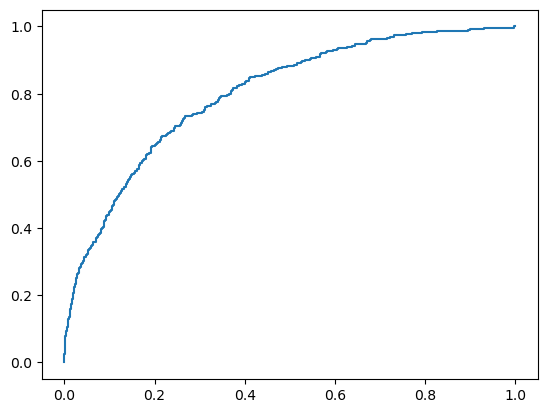

In [50]:
# prediction probability
y_pred_proba = model.predict_proba(X_test)

# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(y_test, y_pred_proba[:,1])
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.show()

In [51]:
# AUC
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, y_pred_proba[:,1])
score

0.8013717738174887

If the false alarm rate is interpreted as the cost, then the hit rate is the benefit, so it can also be said that under the same threshold, we hope that the false alarm rate (cost) is as small as possible, the hit rate (benefit) is as high as possible, the idea is reflected in the graph is the curve as steep as possible, the closer the curve is to the upper left corner of the curve indicates that under the same threshold conditions, the higher the hit rate is, the smaller the false alarm rate is, the more complete the model is. The better the model. To put it in another way, a perfect model is one in which the false alarm rate (FPR) is close to 0 and the hit rate (TPR) is close to 1 at different thresholds, and this feature is reflected in the graph that the curve is very close to the point (0, 1), i.e., the curve is very steep, and it can be numerically represented by **.


Numerically, the strength of the model can be measured by the **AUC value**, which refers to the area under the curve, which usually ranges from 0.5 to 1, with 0.5 indicating a random judgement and 1 indicating a perfect model.
In commercial practice, because of the existence of many disturbance factors, the AUC value can reach 0.75 or more is already acceptable, if it can reach 0.85 or more, it is a very good model.

**The criteria for evaluating models are not only accuracy and AUC, we still need to focus on precision, recall, and F1 scores.**

In [52]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score


# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Precision
precision = precision_score(y_test, y_pred)
print('Precision:', precision)

# Recall
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

# F1 score
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

# AUC score
# Make sure that y_pred_proba is pointing to the probability of the positive class
auc = roc_auc_score(y_test, y_pred_proba[:, 1]) # If y_pred_proba is one-dimensional, remove [:, 1]
print('AUC Score:', auc)


Accuracy: 0.9821396571292037
Precision: 0.5217391304347826
Recall: 0.04
F1 Score: 0.07430340557275542
AUC Score: 0.8013717738174887


1. Accuracy:
    This is the proportion of correctly predicted samples out of the total number of samples. A high accuracy means that the model has produced a large number of correct predictions overall. Here, the accuracy is 98.21%, indicating that the model has correctly predicted most of the samples.

2. Precision:
    Precision refers to the proportion of correctly classified positive samples (e.g., fraud) out of all samples predicted as positive by the model. Here, the precision is 52.17%, meaning that when the model predicts a sample as positive, there is about a 50% chance that it is actually positive.

3. Recall:
    Recall represents the proportion of actual positive samples that the model successfully predicts as positive. Here, the recall is 4%, meaning that the model identifies only a small fraction of the actual positive cases.

4. F1 Score:
    The F1 score is the harmonic mean of precision and recall, ranging from 0 to 1. It balances precision and recall, making it a useful metric when both are important. Here, the F1 score is 7.43%, which is quite low, indicating poor overall performance in terms of both precision and recall.

5. AUC Score (Area Under the ROC Curve):
    AUC measures the ability of the model to rank positive samples before negative ones. It ranges from 0 to 1, with a higher value indicating better performance. Here, the AUC score is 80.14%, suggesting that the model has a relatively good ability to distinguish between positive and negative samples.

**Conclusion:**
Although the model has a high accuracy, this is likely due to the fact that the dataset contains far more negative (non-fraud) samples than positive (fraud) ones. As a result, the model achieves high accuracy simply by predicting the majority class. However, both precision and recall are quite low, especially recall at only 4%, indicating that the model fails to effectively detect positive cases.

In real-world applications such as fraud detection, failing to identify a large number of actual fraudulent cases can lead to serious consequences. Therefore, the model may require further adjustments to improve both precision and recall, with a particular focus on enhancing recall.

### Random Undersampling

Random Undersampling (RUS) is a technique for handling imbalanced datasets. In an imbalanced dataset, one class has significantly more samples than the other(s). The goal of random undersampling is to balance the class distribution by randomly removing samples from the majority class, thereby reducing its size.

**It is clear that there are far fewer firms with financial malpractice than without financial malpractice in this dataset, and therefore random undersampling applies**

In [53]:
pip install imbalanced-learn

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [54]:
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier

rus = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

model = LGBMClassifier()  
model.fit(X_resampled, y_resampled)

LGBMClassifier()

In [55]:
y_pred = model.predict(X_test)
print(y_pred)

[0. 0. 1. ... 0. 1. 0.]


In [56]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
score

0.7061704796607132

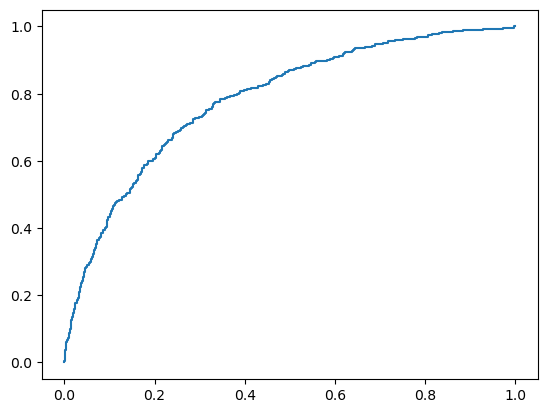

In [57]:
y_pred_proba = model.predict_proba(X_test)

# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(y_test, y_pred_proba[:,1])
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.show()

In [58]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Precision
precision = precision_score(y_test, y_pred)
print('Precision:', precision)

# Recall
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

# F1 score
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

# AUC score
auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print('AUC Score:', auc)


Accuracy: 0.7061704796607132
Precision: 0.04312561819980218
Recall: 0.7266666666666667
F1 Score: 0.08141923436041083
AUC Score: 0.7835518926261583


### Feature importance

In [61]:
features = X.columns  # get features
importances = model.feature_importances_  # get importance

importances_df = pd.DataFrame()
importances_df['Features'] = features
importances_df['Importance'] = importances
importances_df.sort_values('Importance', ascending=False)

,Features,Importance
0,LargestHolderRate,415
6,F081901B,322
3,F031501A,309
5,F051901B,302
4,F051801B,298
1,F032501B,285
10,Fog,251
2,F032601B,223
9,EmotionIndex,221
7,F101201B,187


### 6. Parameter tuning

The tuning ranges for each parameter of LightGBM are referenced from the classical literature (Wang and Ni, 2020; Barnwal, Cho, and Hocking, 2020): max_depth ranges from 6-20, num_leaves from 40-4096, min_child_samples from 18-22, min_child_weight from 0.001-0.002, bagging_fraction from 0.8-1, bagging_freq from 2-5, and min_child_weight from 0.001-0.002. 22, min_child_weight ranges from 0.001-0.002, bagging_fraction ranges from 0.8-1, bagging_freq ranges from 2-5, reg_alpha ranges from 0.001-0.02, reg_lamda ranges from 2-8, learning_rateranges from 0.005-0.02, num_iteration ranges from 200-500, and adjusted by spacing until the trained model recall (Recall) is maximum.

In [62]:
# Reconstruct LGBM classifier
model = LGBMClassifier(bagging_fraction = 0.8, bagging_freq = 2, learning_rate = 0.01, max_depth = 10, min_child_samples = 20, min_child_weight = 0.001, n_estimators = 400, num_leaves = 40, reg_alpha = 0.01, reg_lambda = 2)
model.fit(X_resampled, y_resampled)

# Check accuracy
y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print(score)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
0.7014515261931784


In [66]:
import pickle
import os


# set save path
folder_path = '/Users/tangyinbo/Documents/Study/大三上/智能财务/啊组作业/data'
filename = os.path.join(folder_path, 'saved_model.pkl')

# save
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print(f"model is saved in {filename}")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/tangyinbo/Documents/Study/大三上/智能财务/个人作业/data/saved_model.pkl'

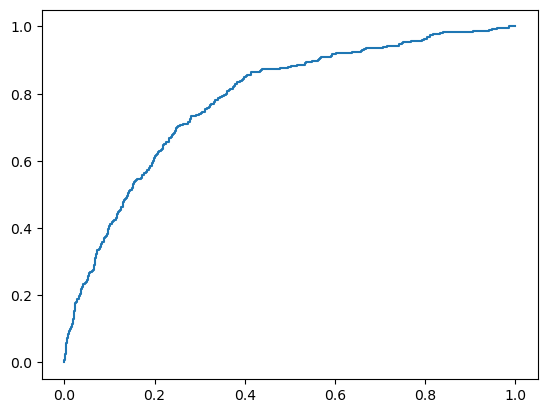

In [49]:
y_pred_proba = model.predict_proba(X_test)

from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(y_test, y_pred_proba[:,1])
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.show()

In [50]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Precision
precision = precision_score(y_test, y_pred)
print('Precision:', precision)

# Recall
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

# F1
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

# AUC
auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print('AUC Score:', auc)


Accuracy: 0.7014515261931784
Precision: 0.043173862310385065
Recall: 0.74
F1 Score: 0.08158765159867695
AUC Score: 0.7841737120613101


1. **Accuracy**: 70.15%
  - A high accuracy rate indicates that the model is able to correctly predict the majority of the sample as a whole. However, this metric may become less reliable due to the problem of category imbalance.If there are far more samples in the negative categories than in the positive categories, the model may tend to predict the most common categories, thus improving accuracy.

2. **Precision**: 4.32%
   - The very low precision rate means that in the cases where the model predicts a positive class, very few of the predictions are correct. This can lead to problems in practical applications, as it suggests that the model is producing a large number of false positive results.

3. **Recall**: 74%
    - The relatively high recall rate indicates that the model is able to capture the majority of cases with actual positive classes. This is important in applications where the consequences of missing positive classes are severe, such as disease screening or fraud detection.

4. **F1 Score**: 8.16%
   - The F1 score is a reconciled average of precision and recall, which takes into account the balance between the two. Due to the extremely low precision rate, the F1 score remains low despite the high recall rate.This indicates that the model is not precise in identifying positive classes.

5. **AUC Score**: 78.42%
   - Higher AUC scores indicate that the model does a relatively good job of distinguishing between positive and negative categories, as AUC is not affected by category imbalance. AUC is a particularly useful performance metric in unbalanced datasets.

From these metrics, the model seems to be able to identify positive classes well (as shown by the recall), but at the same time it performs poorly in terms of precision, resulting in a very low F1 score.This may be due to the fact that the model is too sensitive to samples that are actually negative, generating too many false positives. However, the model can be applied in detecting the existence of financial fraud in listed companies based on the principle of precaution, as we would rather suspect the good guys (false positives) than let the bad guys (listed companies with fraudulent behaviour) off the hook.

### Feature importance

In [150]:
features = X.columns
importances = model.feature_importances_ 

importances_df = pd.DataFrame()
importances_df['Features'] = features
importances_df['importance'] = importances
importances_df.sort_values('importance', ascending=False)

,特征名称,特征重要性
0,LargestHolderRate,1788
6,F081901B,1494
5,F051901B,1428
1,F032501B,1328
4,F051801B,1254
3,F031501A,1173
9,EmotionIndex,1078
10,Fog,1032
2,F032601B,889
7,F101201B,845


It can be observed that the largest shareholder's ownership proportion is the most important feature. Based on information asymmetry theory, we propose two hypotheses:

**1. The Conflict Between Managers and Shareholders**
Managers have an incentive to conceal internal information from external owners (shareholders). When ownership is concentrated, large shareholders actively engage in corporate governance. Conversely, when ownership is dispersed, shareholders lack the motivation to monitor management closely, creating opportunities for managers to commit financial fraud for personal gain.

Example:
Manipulating financial reports to meet annual targets and secure performance-based bonuses.

**2. The Conflict Between Shareholders and Investors Through Managerial Collusion**
When ownership is highly concentrated in a single shareholder, they exert significant influence over internal governance. This dominant shareholder may collude with management to engage in financial fraud for personal benefit.

Example:
Earnings management to avoid debt default and maintain financial stability.

## XGboost Model

### Random Undersampling

In [151]:
!pip install xgboost

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [152]:
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

rus = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [153]:
y_pred = model.predict(X_test)
print(y_pred)

[0 0 1 ... 0 0 0]


In [154]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
score

0.6976883101367899

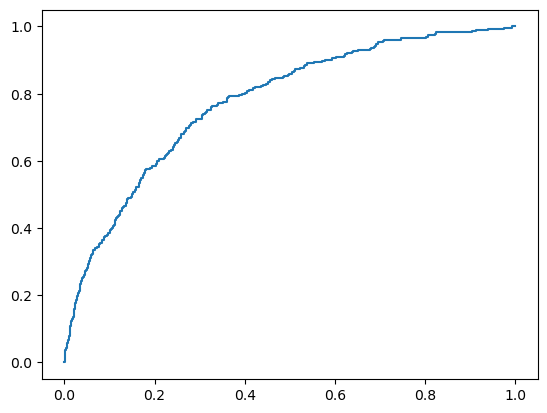

In [155]:
y_pred_proba = model.predict_proba(X_test)

# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(y_test, y_pred_proba[:,1])
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.show()

In [156]:
# AUC
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, y_pred_proba[:,1])
score

0.776376132838635

In [157]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Precision
precision = precision_score(y_test, y_pred)
print('Precision:', precision)

# Recall
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

# F1
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

# AUC
auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print('AUC Score:', auc)

Accuracy: 0.6976883101367899
Precision: 0.04177093358999037
Recall: 0.7233333333333334
F1 Score: 0.07898089171974522
AUC Score: 0.776376132838635


### Feature importance

In [158]:
features = X.columns  # 获取特征名称
importances = model.feature_importances_  # 获取特征重要性

# 通过二维表格形式显示
importances_df = pd.DataFrame()
importances_df['features'] = features
importances_df['importance'] = importances
importances_df.sort_values('importance', ascending=False)

,特征名称,特征重要性
7,F101201B,0.186138
5,F051901B,0.096908
0,LargestHolderRate,0.090765
10,Fog,0.089099
9,EmotionIndex,0.088676
4,F051801B,0.084351
1,F032501B,0.083009
3,F031501A,0.078787
6,F081901B,0.078763
8,InternalControlStrength,0.065462


### Parameter tunning

{'bagging_fraction': 0.8, 'bagging_freq': 2, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 0.001, 'n_estimators': 400, 'num_leaves': 40, 'reg_alpha': 0.01, 'reg_lambda': 2}

In [159]:
# Reconstruct XGBoost classifier
model = XGBClassifier(max_depth = 10 , 
                      n_estimators = 400, 
                      learning_rate = 0.01,  
                      num_leaves = 40, 
                      reg_alpha = 0.01, 
                      reg_lambda = 2, 
                      bagging_fraction = 0.8, 
                      bagging_freq = 2, 
                      min_child_samples = 20, 
                      min_child_weight = 0.001)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print(score)

/Users/tangyinbo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:50:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bagging_fraction", "bagging_freq", "min_child_samples", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)


0.6877128009079505


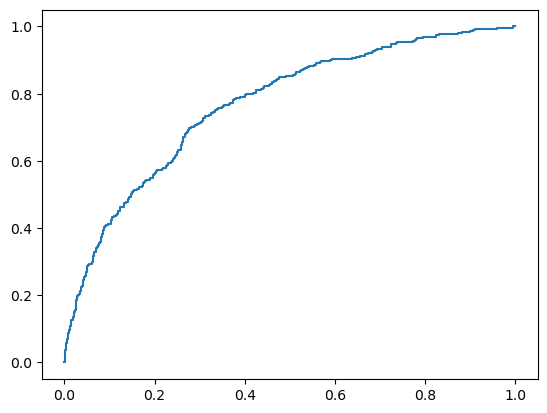

In [160]:
y_pred_proba = model.predict_proba(X_test)

# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(y_test, y_pred_proba[:,1])
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.show()

In [162]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Precision
precision = precision_score(y_test, y_pred)
print('Precision:', precision)

# Recall
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

# F1
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

# AUC
auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print('AUC Score:', auc)

Accuracy: 0.6877128009079505
Precision: 0.040983606557377046
Recall: 0.7333333333333333
F1 Score: 0.07762879322512349
AUC Score: 0.7682472680088397


Model performance improvement is not always guaranteed by simply adjusting parameters. Parameter tuning may enhance certain metrics while causing declines in others.

- Accuracy slightly decreased from 69.77% to 68.77%.
- Precision slightly dropped from 4.18% to 4.10%.
- Recall slightly increased from 72.33% to 73.33%.
- F1 Score slightly declined from 7.90% to 7.76%.
- AUC Score slightly decreased from 77.64% to 76.82%.

The decline in performance can be attributed to multiple factors. Below are some potential reasons identified by our team:

**Overfitting:**

In the initial model, parameter settings might have been more suited to the training data. However, when applied to test or unseen data, the model may fail to maintain the same performance level. If parameter tuning increases the model’s complexity, it might perform better on the training set but worse on the test set, which is a typical sign of overfitting.

**Parameter Selection:**

Some parameter choices may not align well with the nature of the problem, or the adjustments may have been made in the wrong direction. For instance, the learning rate could be set too high or too low, or hyperparameters such as tree depth and the number of leaves might be suboptimal.

**Randomness:**

The inherent randomness in the training process may also contribute to performance fluctuations. For example, changes in stochastic gradient descent (SGD) or variations in random seed initialization could impact the results.

## Model Comparision

### LighGBM and  XGBoost

### Comparison between LightGBM in the reference paper and LightGBM in this project 

When comparing the LightGBM model in the reference paper with the LightGBM model in this project, we can evaluate performance across multiple metrics and explore potential improvements:

**1. Accuracy**
 - Reference Paper: 78.00%
 - This Project: 70.15%

The accuracy of this project is lower than that of the reference paper, indicating that the model in this project has a lower proportion of correctly predicted samples.

**2. Precision**
 - Reference Paper: 6.00%
 - This Project: 4.32%

The proportion of correctly predicted positive cases is also lower in this project compared to the reference model.

**3. Recall**
 - Reference Paper: 74.80%
 - This Project: 74.00%

Recall is almost identical in both models, indicating that both models perform well in identifying actual positive 
samples.

**4. F1 Score**
 - Reference Paper: 11.10%
 - This Project: 8.16%

The F1 score is lower in this project, suggesting that the balance between precision and recall is not as optimal as in the reference model.

**5. AUC Score**
 - Reference Paper: 76.50%
 - This Project: 78.42%

The AUC score is a highlight of this project’s model, outperforming the reference paper’s model. This suggests that this project’s model is more effective at distinguishing between positive and negative classes.

**Potential Reasons for Performance Differences**

**1. Text Complexity**

The definition of complex vocabulary is unclear and requires a more refined lexicon.
Syntactic analysis could further enhance the model's understanding of text complexity.
Sentiment Analysis

**2. The classification of sentiment words is not detailed enough.**

A more comprehensive sentiment dictionary, specifically tailored for financial reports, could improve the differentiation between positive and negative sentiments.
Internal Control Indicators

**3. Independent directors' participation is an important factor.**

However, other internal control factors, such as the robustness of the internal control system and weight of internal audits, should also be considered. Future models can incorporate additional internal control factors to provide a more comprehensive assessment of internal control quality.

**4. Annual Report Data Coverage**

Some annual reports were missing in the dataset.
Future work should ensure a complete dataset, enriching the training samples to improve model accuracy.

**Conclusion**

Although this project’s model has lower accuracy and precision compared to the reference paper’s model, it still demonstrates strong recall in detecting financial fraud in listed companies.

This suggests that the model is valuable for real-world applications, particularly for helping external investors identify potential financial irregularities and risks.

## Conclusion

After training LightGBM and XGBoost models by inputting financial and textual data** from **2000-2023 and comparing their performances on key performance metrics such as **accuracy, precision, recall, F1 score and AUC score**, we find that **LightGBM performs slightly better on all the metrics**. In particular, the Recall Rate and AUC Score show that LightGBM has strong detection capabilities and can effectively check for corporate fraud. Specifically, LightGBM has a recall rate of 74%, meaning that it is able to identify 74% of actual fraud cases. And its AUC score is 78.42%, which indicates that the model has a good performance in distinguishing fraud and non-fraud companies. However, the poor performance on the PRECESSION metric may be due to the low positive category data (presence of financial fraud), though it can be accepted under this experiment.

## Reference